In [122]:
#given a dataset for H(z), z, err(H), we do an MCMC analysis and find corner plots for the data

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
import scipy
from IPython.display import display, Math
import pandas as pd

# Background

CMB data gives us a value for the shift parameter (R), the acoustic scale ($\ell_a$) and $\Omega_b h^2$.

In our theory these are given by:

$R = \sqrt{\Omega_mH_0^2}(1+ z_{CMB})D_A(z_{CMB})$
and 
$\ell_a = (1+z_{CMB}) \frac{\pi D_A(z_{CMB})}{r_s(z_{CMB})}$

with angular diameter distance:
$D_A(z) = \frac{1}{H_0(1+z)}\int^z_0 \frac{\text{d}z}{E(z)}$

and comoving sound horizon:
$r_s(z) = \frac{1}{H_0} \int^a_0 \frac{\text{d}a}{aE(a)\sqrt{3(1+\bar{R_b})a}}$

We have $R_b = 31500 \Omega_b h^2 \left(\frac{T_{CMB}}{2.7K}\right)^{-4}$, $T_{CMB} = 2.275K$

and $z_{CMB} = 1048[1 + 0.00124(\Omega_bh^2)^{-0.738}][1 + g_1(\Omega_mh^2)^{g_2}]$

with $g_1 = \frac{0.0783 (\Omega_bh^2)^{-0.238}}{1+39.5(\Omega_bh^2)^{0.763}}$ and $g_2 = \frac{0.56}{1 + 21.1(\Omega_bh^2)^{1.81}}$

In [123]:
# ------ OUR DATA -------

# covariance matrix MULTIPLIED BY 1E8 (C_CMB = C_CMB_10e8*(1e-8))

C_CMB_10e8 = np.array([[1598.9554 , 17112.007 , -36.311179],
              [17112.007 , 811208.45 , -494.79813],
              [-36.311179 , -494.79813 , 2.1242182]])

# our difference between model and data
def X_array(R , l_a , Omgb_hsquared):
    return np.array([R - 1.74963, l_a - 301.80845, Omgb_hsquared - 0.02237])

In [124]:
#------ EQUATIONS FOR OUR THEORY ------

# gives X(z) 
def X(z, cosmo):
    
    H0 , Omega_b , Omega_c , Omega_k , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    h = H0/100
    Omega_r = 2.47e-5*h**(-2)
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0
def E(z , cosmo):
    
    H0 , Omega_b , Omega_c , Omega_k , alpha_tilde = cosmo
    h = H0/100
    Omega_r = 2.47e-5*h**(-2)
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    if alpha_tilde == 0:
        return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        return np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2*alpha_tilde*Omega_k*(1+z)**2))/(2 * alpha_tilde))

# Used to find z_CMB
def g1(Omgb_hsquared):
    return (0.0783*(Omgb_hsquared)**(-0.238))/\
           (1 + 39.5*Omgb_hsquared**(0.763))

# Used to find z_CMB
def g2(Omgb_hsquared):
    return 0.56/(1 + 21.1*Omgb_hsquared**(1.81))

# redshift at which the BB occurs
def z_CMB(Omgb_hsquared):
    return 1048*(1+0.00124*Omgb_hsquared**(-0.738))*\
           (1 + g1(Omgb_hsquared)*Omgb_hsquared**g2(Omgb_hsquared))

# Used to find r_s
def R_b(Omgb_hsquared):
    return 31500*Omgb_hsquared*(2.275/2.7)**(-4)

# Angular diameter distance
def D_A(z, cosmo):
    H0 , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    return scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z)[0]/(H0*(1+z))

# Comoving sound horizon (to find acoustic scale)
def r_s(z, cosmo):
    H0 , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    h = H0/100
    Omg_r = 2.47e-5*h**(-2)
    Omg_l = 1 - Omg_b - Omg_c - Omg_k + \
            alpha_t*(1 - 2*Omg_k + Omg_k**2)
    ans = scipy.integrate.quad(lambda x: 1/(x*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2))*x)), 0 , 1/(1+z))[0]/H0
    return ans

# Shift parameter
def R(z, cosmo):
    H0 , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    h = H0/100
    Omg_m = Omg_b + Omg_c
    return np.sqrt(Omg_m*H0**2)*(1+z_CMB(Omg_b*h**2))*D_A(z_CMB(Omg_b*h**2), cosmo)

# Acoustic scale
def l_A(z, cosmo):
    H0 , Omg_b , Omg_c , Omg_k , alpha_t = cosmo
    h = H0/100
    Omg_m = Omg_b + Omg_c
    return (1+z_CMB(Omg_b*h**2))*np.pi*D_A(z_CMB(Omg_b*h**2), cosmo)/r_s(z_CMB(Omg_b*h**2),cosmo)

In [125]:
def log_likelihood(theta):
    Omg_b , Omg_c , H0 = theta #f is the underestimation of the variance? No idea what it means
    Omg_r = 2.47e-5*(H0/100)**-2
    cosmo = [H0 , Omg_b , Omg_c , 0 , 0]
    z = z_CMB(Omg_b*(H0/100)**2)
    X_mcmc = X_array(R(z, cosmo) , l_A(z, cosmo) , Omg_b*(H0/100)**2)
    return -0.5 *( np.matmul(np.matmul(np.transpose(X_mcmc),np.linalg.inv(C_CMB_10e8)),X_mcmc)*1e-8)

In [126]:
def log_prior(theta):
    Omg_b , Omg_c , H0 = theta
    if 55 < H0 < 91 and 0.1 < Omg_c < 0.9 and 0.1 < Omg_b < 0.9:
        return 0.0
    return -np.inf

In [127]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [128]:
# Choose the seed parameters.
H0_est = 69
Omg_b_est = 0.3
Omg_c_est = 0.3

In [129]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [Omg_b_est , Omg_c_est , H0_est] + 1e-2 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [00:29<00:00, 16.77it/s]


(1300, 3)


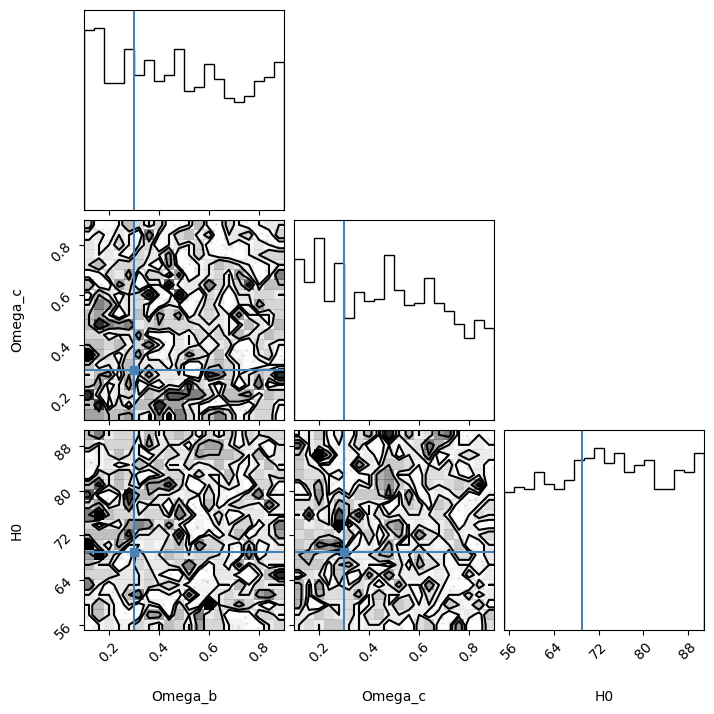

In [130]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["Omega_b","Omega_c", "H0"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[Omg_b_est ,Omg_c_est , H0_est]
);

50
500
3
500


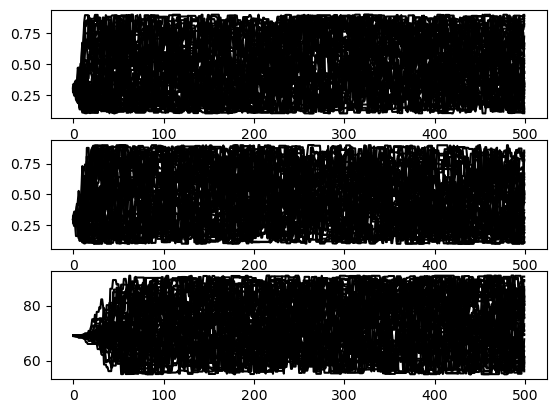

In [131]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(3)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")


In [132]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [133]:
X = np.array([1,2,3])
C = np.array([[0.01,3,4],[0.002,3,5],[4,2,1]])
print(np.linalg.inv(C))
print((np.matmul(np.matmul(X,np.linalg.inv(C)),np.transpose(X))))



[[-0.58626466  0.41876047  0.25125628]
 [ 1.67487437 -1.33919598 -0.00351759]
 [-1.00469012  1.00335008  0.00201005]]
2.001005025125628


In [134]:
# --- PRINT DIFFERENCE OF DATA WITH ESTIMATED PARAMS -----

for Omg_b, Omg_c, H0 in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    cosmo = [H0 , Omg_b , Omg_c , 0 , 0]
    z = z_CMB(Omg_b*(H0/100)**2)
    X_mcmc = X_array(R(z, cosmo) , l_A(z, cosmo) , Omg_b*(H0/100)**2)/np.array([R(z, cosmo) , l_A(z, cosmo) , Omg_b*(H0/100)**2])
    print("loglikelihood =", log_likelihood([Omg_b, Omg_c, H0]))

loglikelihood = -0.03242584177233542
loglikelihood = -0.01426518831591022
loglikelihood = -0.025224645982711943
loglikelihood = -0.015192827655897178
loglikelihood = -0.01567961477829433
loglikelihood = -0.005705011297536887
loglikelihood = -0.03311147497290622
loglikelihood = -0.01367099585320525
loglikelihood = -0.006279273709436371
loglikelihood = -0.006229562720398421
loglikelihood = -0.009499460546383067
loglikelihood = -0.01367099585320525
loglikelihood = -0.017168116345098856
loglikelihood = -0.04043698289589374
loglikelihood = -0.01563568321203166
loglikelihood = -0.02294899191237696
loglikelihood = -0.007403254979471148
loglikelihood = -0.024261728080425482
loglikelihood = -0.02418702418337881
loglikelihood = -0.005177614696786811
loglikelihood = -0.03207330547807566
loglikelihood = -0.02871121237143284
loglikelihood = -0.03976122551648743
loglikelihood = -0.017819219121746797
loglikelihood = -0.0076667374666253675
loglikelihood = -0.017154890458422684
loglikelihood = -0.03317